# Imports etc.

In [1]:
import ipdb
import numpy as np
import os
import pandas as pd
import plotnine as gg
import scipy
gg.theme_set(gg.theme_bw)

from Functions import replace_nans, get_info_from_fullID

In [2]:
fitted_param_dir = 'C:/Users/maria/MEGAsync/SLCN/PShumanData/fitting/mice/'
plot_dir = 'C:/Users/maria/MEGAsync/SLCN/models/plots'
mouse_data_dir = 'C:/Users/maria/MEGAsync/SLCN/PSMouseData'

In [3]:
save_or_load_true_mouse_dat = 'save'  # 'save', 'load'
save_or_load_sim_mouse_dat = 'save'  # 'save', 'load'

# Functions to load and format mouse data

In [4]:
def read_in_raw_mouse_data(mouse_data_dir, n_trials):
    
    # Load data
    rewards_j = pd.read_csv(os.path.join(mouse_data_dir, 'Juvi_Reward.csv')).T.values[:n_trials]
    rewards_a = pd.read_csv(os.path.join(mouse_data_dir, 'Adult_Reward.csv')).T.values[:n_trials]
    actions_j = pd.read_csv(os.path.join(mouse_data_dir, 'Juvi_Choice.csv')).T.values[:n_trials]
    actions_a = pd.read_csv(os.path.join(mouse_data_dir, 'Adult_Choice.csv')).T.values[:n_trials]
    correct_actions_j = pd.read_csv(os.path.join(mouse_data_dir, 'Juvi_TaskData.csv')).T.values[:n_trials]
    correct_actions_a = pd.read_csv(os.path.join(mouse_data_dir, 'Adult_TaskData.csv')).T.values[:n_trials]
    fullID_j = pd.read_csv(os.path.join(mouse_data_dir, 'Juvi_AnimalID.csv')).T.values.flatten()
    fullID_a = pd.read_csv(os.path.join(mouse_data_dir, 'Adult_AnimalID.csv')).T.values.flatten()

    # Clean data
    n_trials_per_animal = np.sum(np.invert(np.isnan(rewards_j)), axis=0)
    n_trials = np.round(np.percentile(n_trials_per_animal, 0.8)).astype('int')
    rewards_j = replace_nans(rewards_j).astype('int')
    actions_j = replace_nans(actions_j).astype('int')
    rewards_a = replace_nans(rewards_a).astype('int')
    actions_a = replace_nans(actions_a).astype('int')
    correct_actions_j = replace_nans(correct_actions_j).astype('int')
    correct_actions_a = replace_nans(correct_actions_a).astype('int')

    # Combine juvenile and adult data
    fullIDs = np.concatenate([fullID_j, fullID_a])
    correct_actions = np.hstack([correct_actions_j, correct_actions_a])
    actions = np.hstack([actions_j, actions_a])
    corrects = (actions == correct_actions).astype('int')
    rewards = np.hstack([rewards_j, rewards_a])  # (n_trials, n_cols)
    rewards[corrects == 0] = 0  # to fix errors of replace_nans
    
    return {
        'fullIDs': fullIDs,
        'animals': [int(str(fullID)[:-5]) for fullID in fullIDs],
        'ages': [int(str(fullID)[-5:-2]) for fullID in fullIDs],
        'rewards': rewards,
        'actions': actions,
        'correct_actions': correct_actions,
        'corrects': corrects,
    }

# # Example use
# raw_dat = read_in_raw_mouse_data(mouse_data_dir, n_trials=725)
# raw_dat

In [5]:
def format_mouse_data(raw_dat, save_as_csv=True):
    
    true_dat = pd.DataFrame()
    for i, fullID in enumerate(raw_dat['fullIDs']):
        
        # Basic info
        subj_dat = {
            'action': raw_dat['actions'][:, i],
            'reward': raw_dat['rewards'][:, i],
            'correct': raw_dat['corrects'][:, i],
            'correct_action': raw_dat['correct_actions'][:, i],
            'trial': range(len(raw_dat['actions'])),
            'block': np.append([0], np.cumsum(np.abs(np.diff(raw_dat['correct_actions'][:, i])))),
            'fullID': [fullID] * len(raw_dat['actions']),
                }
        subj_dat.update(get_info_from_fullID(fullID, length=len(subj_dat['action'])))
        subj_dat = pd.DataFrame(subj_dat)

        # Session info
        for age in np.unique(subj_dat.age):
            subj_dat.loc[subj_dat.age == age, 'rew_1ago'] = np.append(np.nan, subj_dat['reward'][:-1])
            subj_dat.loc[subj_dat.age == age, 'rew_2ago'] = np.append(np.nan, subj_dat['rew_1ago'][:-1])
            subj_dat.loc[subj_dat.age == age, 'switch'] = np.append(np.nan, np.abs(np.diff(subj_dat.action)))

            # Block info
            for block in np.unique(subj_dat.block):
                sub_idx = (subj_dat.block == block) * (subj_dat.age == age)
                block_length = sum(sub_idx)

                if block_length > 5:
                    block_trial = range(block_length)
                    trials2switch = np.append(np.arange(block_length-3), np.arange(-3, 0))
                else:
                    block_trial = [np.nan] * block_length
                    trials2switch = [np.nan] * block_length

                subj_dat.loc[sub_idx, 'block_length'] = block_length
                subj_dat.loc[sub_idx, 'block_trial'] = block_trial
                subj_dat.loc[sub_idx, 'trials2switch'] = trials2switch

        true_dat = true_dat.append(subj_dat)

    # Session and gender
    for animal in np.unique(true_dat.animal):
        ani_age = true_dat.loc[true_dat.animal == animal, 'age']
        true_dat.loc[true_dat.animal == animal, 'session'] = ani_age - np.min(ani_age)
    true_dat['rew_12ago'] = [str(r1)[0] + str(r2)[0] for r1, r2 in zip(true_dat['rew_1ago'], true_dat['rew_2ago'])]
    
    # Save as csv
    if save_as_csv:
        true_dat.to_csv(os.path.join(mouse_data_dir, 'formatted_mouse_data.csv'))
        
    return true_dat

# # Example use
# true_dat = format_mouse_data(raw_dat, save_as_csv=True)
# true_dat

# Functions to load and format simulated data

In [6]:
# Get remaining info for this simulation
def format_sim_data(sim_dat, model_name, selected_mouse=0, save_as_csv=True):
    """
    Takes raw `sim_data` (e.g., read in from os.path.join(fitted_param_dir, 'simulations/simulated_mice_{}_nagents{}.csv'.format(model_name, n_agents)))
    Adds all the columns necessary for behavioral analyses.
    """
    
    # Pull out behavior of one specific simulation into separate columns
    for col in ['actionall', 'rewardall', 'correctall']:
        sim_dat[col[:-3]] = sim_dat[col].apply(lambda x: x[2 * selected_mouse + 1]).astype('int')
        
    # Add gender and session for each simulated animal
    for animal in np.unique(sim_dat.animal):
        print('animal {} / {}'.format(animal, len(np.unique(sim_dat.animal))))
        sub_idx_a = sim_dat.animal == animal
        sim_dat.loc[sub_idx_a, 'gender'] = get_info_from_fullID(sim_dat.loc[sub_idx_a, 'fullID'].reset_index(drop=True)[0], sum(sub_idx_a))['gender']
        sim_age = sim_dat.loc[sub_idx_a, 'age']
        sim_dat.loc[sub_idx_a, 'session'] = sim_age - min(sim_age)

        # Add rew_1ago, rew_2ago, switch for each session
        for age in np.unique(sim_dat.loc[sub_idx_a, 'age']):
            sub_idx_aa = (sim_dat.animal == animal) * (sim_dat.age == age)
            sim_dat.loc[sub_idx_aa, 'rew_1ago'] = np.append(np.nan, sim_dat.loc[sub_idx_aa, 'reward'][:-1])
            sim_dat.loc[sub_idx_aa, 'rew_2ago'] = np.append(np.nan, sim_dat.loc[sub_idx_aa, 'rew_1ago'][:-1])
            sim_dat.loc[sub_idx_aa, 'switch'] = np.append(np.nan, np.abs(np.diff(sim_dat.loc[sub_idx_aa, 'action'].astype('int'))))

            # Add block_length, block_trial, trials2swtich for each block
            for block in np.unique(sim_dat.loc[sub_idx_aa, 'block']):
                sub_idx_baa = (sim_dat.block == block) * (sim_dat.animal == animal) * (sim_dat.age == age)
                block_length = sum(sub_idx_baa)

                if block_length > 5:
                    block_trial = range(block_length)
                    trials2switch = np.append(np.arange(block_length-3), np.arange(-3, 0))
                else:
                    block_trial = [np.nan] * block_length
                    trials2switch = [np.nan] * block_length

                sim_dat.loc[sub_idx_baa, 'block_length'] = block_length
                sim_dat.loc[sub_idx_baa, 'block_trial'] = block_trial
                sim_dat.loc[sub_idx_baa, 'trials2switch'] = trials2switch

    # Format gender; add rew_12ago and agegroup
    sim_dat['gender'] = sim_dat['gender'].astype('category')
    sim_dat['rew_12ago'] = [str(r1)[0] + str(r2)[0] for r1, r2 in zip(sim_dat['rew_1ago'], sim_dat['rew_2ago'])]
    sim_dat.loc[sim_dat.age > 65, 'agegroup'] = 1  # adults: 69-90
    sim_dat.loc[sim_dat.age < 65, 'agegroup'] = 2  # juveniles: 38-60

    # Save as csv
    if save_as_csv:
        sim_dat.to_csv(os.path.join(mouse_data_dir, 'formatted_sim_mouse_data_{}.csv'.format(model_name)), index=False)
        
    return sim_dat

# # Example use
# n_agents = 10
# modelnames = [f for f in os.listdir(fitted_param_dir) if ('.csv' in f) and ('params' in f) and ('B' not in f)]
# model_names = [modelname.split('_')[1] for modelname in modelnames]
# simulation_dir = os.path.join(fitted_param_dir, 'simulations/simulated_mice_{}_nagents{}.csv'.format(model_name, n_agents))
# sim_dat = pd.read_csv(simulation_dir)
# format_sim_data(sim_dat, model_name, selected_mouse=0, save_as_csv=True)

# Functions to make plots

In [7]:
def make_trials2switch_plot(data, suf=''):
    
    sub_dat = data[data.session < 10]
    g = (gg.ggplot(data, gg.aes('trials2switch', 'correct', color='gender', group='gender'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.coord_cartesian(xlim=(-3, 10))
     + gg.facet_grid('~ agegroup')
    )
    g.draw()
    g.save(os.path.join(plot_dir, 'trials2switch_{}.png'.format(suf)))
    
# # Example use
# make_trials2switch_plot(true_dat, suf='mouse')

In [8]:
def make_12ago_plot(data, suf=''):
    
    sub_dat = data.loc[(data.rew_12ago != '0n') * (data.rew_12ago != '1n') * (data.rew_12ago != 'nn')]

    g = (gg.ggplot(sub_dat, gg.aes('rew_12ago', 'switch', fill='gender', group='gender'))
         + gg.stat_summary(geom='bar', position=gg.position_dodge(width=0.9))
         + gg.stat_summary(position=gg.position_dodge(width=0.9))
         + gg.facet_grid('~ agegroup')
    )
    g.draw()
    g.save(os.path.join(plot_dir, 'rew12back_switch_{}.png'.format(suf)))
    
    g2 = g + gg.aes(y='correct')    
    g2.draw()
    g2.save(os.path.join(plot_dir, 'rew12back_correct_{}.png'.format(suf)))
    
# # Example use
# make_12ago_plot(true_dat, 'mouse')

In [9]:
def make_blocktrial_correct_plot(data, suf):
    
    g = (gg.ggplot(data, gg.aes('block_trial', 'correct', color='gender'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.facet_wrap('~ agegroup')
    )
    g.draw()
    g.save(os.path.join(plot_dir, 'trial_correct_{}.png'.format(suf)))
    
# # Example use
# make_blocktrial_correct_plot(true_dat, 'mouse')

In [10]:
def make_block_correct_plot(data, suf):
    
    g = (gg.ggplot(data, gg.aes('block', 'correct', color='gender', group='gender'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.coord_cartesian(xlim=(0, 20))
     + gg.facet_wrap('~ agegroup')
    )
    g.draw()
    g.save(os.path.join(plot_dir, 'block_correct_{}.png'.format(suf)))
    
# # Example use
# make_block_correct_plot(true_dat, 'mouse')

In [11]:
def make_session_correct_plot(data, suf):

    g = (gg.ggplot(data, gg.aes('session', 'correct', color='gender'))
     + gg.stat_summary()
     + gg.stat_summary(geom='line')
     + gg.facet_wrap('~ agegroup')
    )
    g.draw()
    g.save(os.path.join(plot_dir, 'session_correct_{}.png'.format(suf)))
    
# # Example use
# make_session_correct_plot(true_dat, 'mouse')

# Putting it all together

## Analyze mouse data

Reading in mouse data...


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


Plotting...


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 3485 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\trials2switch_mouse.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 3485 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not s

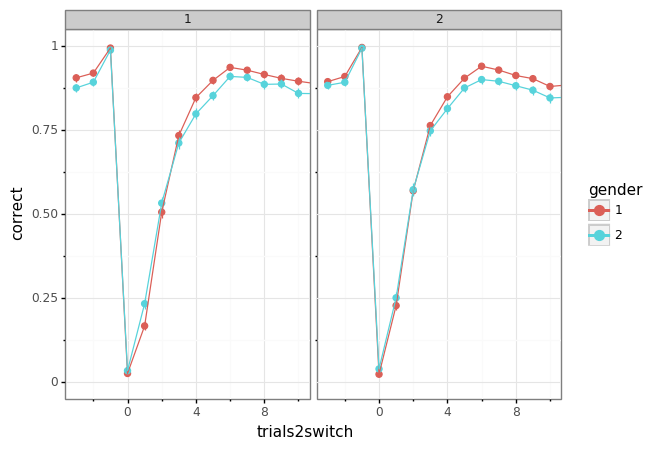

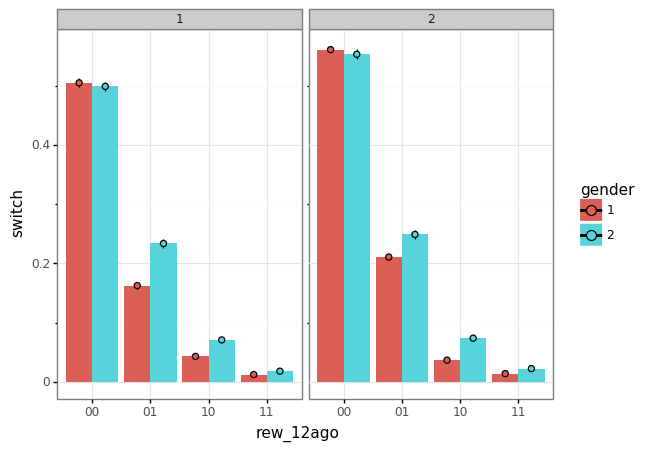

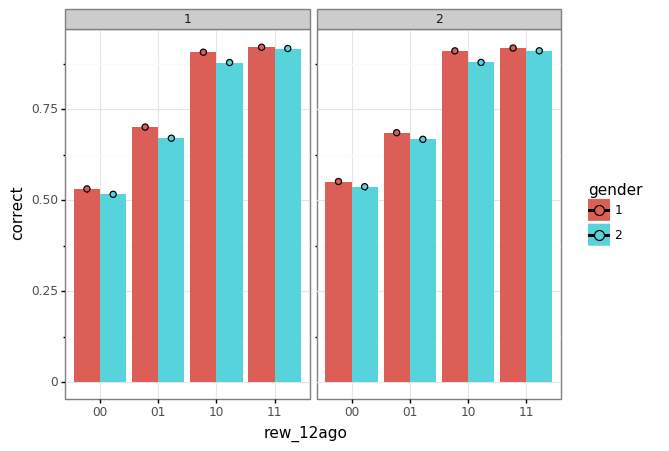

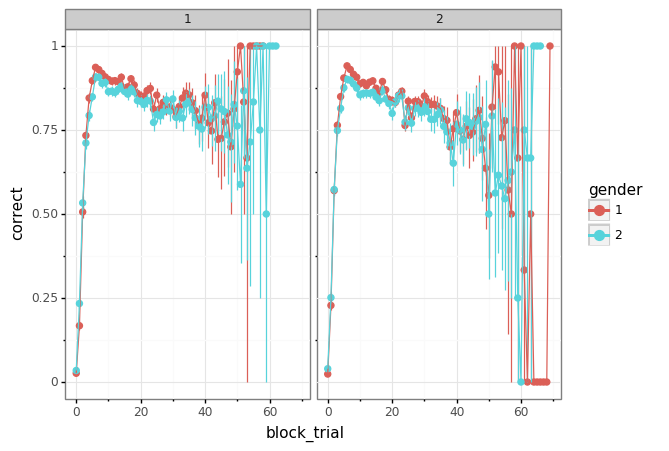

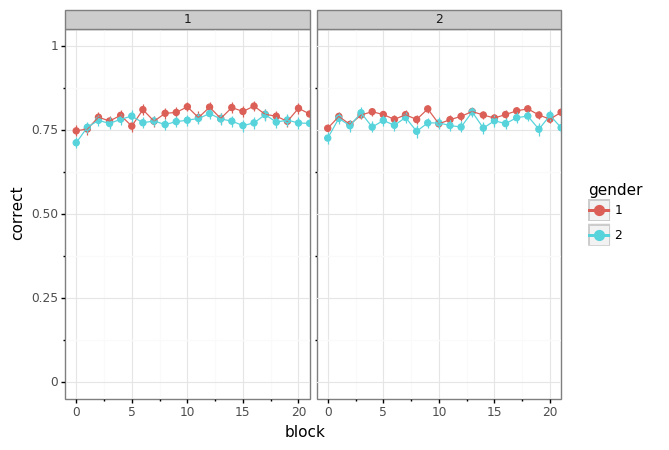

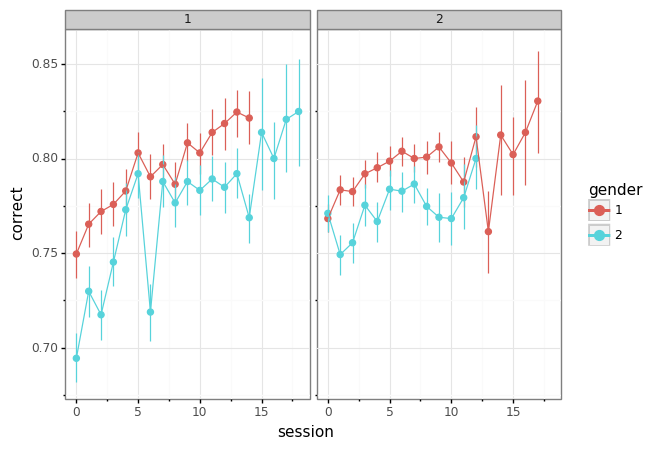

In [12]:
n_trials = 725

# Read in and format mouse data
print("Reading in mouse data...")
if save_or_load_true_mouse_dat == 'save':
    raw_dat = read_in_raw_mouse_data(mouse_data_dir, n_trials)
    true_dat = format_mouse_data(raw_dat, save_as_csv=True)
else:
    true_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_mouse_data.csv'))
true_dat['gender'] = true_dat['gender'].astype('category')

# Plot mouse data
print("Plotting...")
make_trials2switch_plot(true_dat, suf='mouse')
make_12ago_plot(true_dat, 'mouse')
make_blocktrial_correct_plot(true_dat, 'mouse')
make_block_correct_plot(true_dat, 'mouse')
make_session_correct_plot(true_dat, 'mouse')

## Analyze simulated data

Model RLabcd
animal 1 / 31


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


animal 2 / 31
animal 3 / 31
animal 4 / 31
animal 5 / 31
animal 6 / 31
animal 7 / 31
animal 8 / 31
animal 14 / 31
animal 15 / 31
animal 16 / 31
animal 17 / 31
animal 18 / 31
animal 19 / 31
animal 20 / 31
animal 21 / 31
animal 22 / 31
animal 24 / 31
animal 25 / 31
animal 26 / 31
animal 27 / 31
animal 28 / 31
animal 29 / 31
animal 30 / 31
animal 31 / 31
animal 32 / 31
animal 33 / 31
animal 34 / 31
animal 35 / 31
animal 36 / 31
animal 37 / 31
Plotting...


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 1018 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\trials2switch_simRLabcd.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 1018 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is n

Model RLabcpd
animal 1 / 36


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


animal 2 / 36
animal 3 / 36
animal 4 / 36
animal 5 / 36
animal 6 / 36
animal 7 / 36
animal 8 / 36
animal 9 / 36
animal 10 / 36
animal 11 / 36
animal 12 / 36
animal 13 / 36
animal 14 / 36
animal 15 / 36
animal 16 / 36
animal 17 / 36
animal 18 / 36
animal 19 / 36
animal 20 / 36
animal 21 / 36
animal 22 / 36
animal 24 / 36
animal 25 / 36
animal 26 / 36
animal 27 / 36
animal 28 / 36
animal 29 / 36
animal 30 / 36
animal 31 / 36
animal 32 / 36
animal 33 / 36
animal 34 / 36
animal 35 / 36
animal 36 / 36
animal 37 / 36
Plotting...


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 3363 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\trials2switch_simRLabcpd.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 3363 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is 

Model RLabcpnd
animal 1 / 36


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


animal 2 / 36
animal 3 / 36
animal 4 / 36
animal 5 / 36
animal 6 / 36
animal 7 / 36
animal 8 / 36
animal 9 / 36
animal 10 / 36
animal 11 / 36
animal 12 / 36
animal 13 / 36
animal 14 / 36
animal 15 / 36
animal 16 / 36
animal 17 / 36
animal 18 / 36
animal 19 / 36
animal 20 / 36
animal 21 / 36
animal 22 / 36
animal 24 / 36
animal 25 / 36
animal 26 / 36
animal 27 / 36
animal 28 / 36
animal 29 / 36
animal 30 / 36
animal 31 / 36
animal 32 / 36
animal 33 / 36
animal 34 / 36
animal 35 / 36
animal 36 / 36
animal 37 / 36
Plotting...


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 3363 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\trials2switch_simRLabcpnd.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 3363 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is

Model RLabcpnxd
animal 1 / 36


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


animal 2 / 36
animal 3 / 36
animal 4 / 36
animal 5 / 36
animal 6 / 36
animal 7 / 36
animal 8 / 36
animal 9 / 36
animal 10 / 36
animal 11 / 36
animal 12 / 36
animal 13 / 36
animal 14 / 36
animal 15 / 36
animal 16 / 36
animal 17 / 36
animal 18 / 36
animal 19 / 36
animal 20 / 36
animal 21 / 36
animal 22 / 36
animal 24 / 36
animal 25 / 36
animal 26 / 36
animal 27 / 36
animal 28 / 36
animal 29 / 36
animal 30 / 36
animal 31 / 36
animal 32 / 36
animal 33 / 36
animal 34 / 36
animal 35 / 36
animal 36 / 36
animal 37 / 36
Plotting...


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 3363 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\trials2switch_simRLabcpnxd.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 3363 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator i

Model RLabd
animal 1 / 36


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


animal 2 / 36
animal 3 / 36
animal 4 / 36
animal 5 / 36
animal 6 / 36
animal 7 / 36
animal 8 / 36
animal 9 / 36
animal 10 / 36
animal 11 / 36
animal 12 / 36
animal 13 / 36
animal 14 / 36
animal 15 / 36
animal 16 / 36
animal 17 / 36
animal 18 / 36
animal 19 / 36
animal 20 / 36
animal 21 / 36
animal 22 / 36
animal 24 / 36
animal 25 / 36
animal 26 / 36
animal 27 / 36
animal 28 / 36
animal 29 / 36
animal 30 / 36
animal 31 / 36
animal 32 / 36
animal 33 / 36
animal 34 / 36
animal 35 / 36
animal 36 / 36
animal 37 / 36
Plotting...


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 3363 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:363: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure()
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\trials2switch_simRLabd.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\

Model RLabnp2d
animal 1 / 36


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


animal 2 / 36
animal 3 / 36
animal 4 / 36
animal 5 / 36
animal 6 / 36
animal 7 / 36
animal 8 / 36
animal 9 / 36
animal 10 / 36
animal 11 / 36
animal 12 / 36
animal 13 / 36
animal 14 / 36
animal 15 / 36
animal 16 / 36
animal 17 / 36
animal 18 / 36
animal 19 / 36
animal 20 / 36
animal 21 / 36
animal 22 / 36
animal 24 / 36
animal 25 / 36
animal 26 / 36
animal 27 / 36
animal 28 / 36
animal 29 / 36
animal 30 / 36
animal 31 / 36
animal 32 / 36
animal 33 / 36
animal 34 / 36
animal 35 / 36
animal 36 / 36
animal 37 / 36
Plotting...


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 3363 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:363: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure()
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\trials2switch_simRLabnp2d.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Use

Model RLab
animal 1 / 36


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\pandas\core\computation\expressions.py:194: UserWarning: evaluating in Python space because the '*' operator is not supported by numexpr for the bool dtype, use '&' instead
  op=op_str, alt_op=unsupported[op_str]


animal 2 / 36
animal 3 / 36
animal 4 / 36
animal 5 / 36
animal 6 / 36
animal 7 / 36
animal 8 / 36
animal 9 / 36
animal 10 / 36
animal 11 / 36
animal 12 / 36
animal 13 / 36
animal 14 / 36
animal 15 / 36
animal 16 / 36
animal 17 / 36
animal 18 / 36
animal 19 / 36
animal 20 / 36
animal 21 / 36
animal 22 / 36
animal 24 / 36
animal 25 / 36
animal 26 / 36
animal 27 / 36
animal 28 / 36
animal 29 / 36
animal 30 / 36
animal 31 / 36
animal 32 / 36
animal 33 / 36
animal 34 / 36
animal 35 / 36
animal 36 / 36
animal 37 / 36
Plotting...


C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\layer.py:360: PlotnineWarning: stat_summary : Removed 3363 rows containing non-finite values.
  data = self.stat.compute_layer(data, params, layout)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:363: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  figure = plt.figure()
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
  from_inches(height, units), units), PlotnineWarning)
C:\Users\maria\Anaconda3\envs\PYMC3\lib\site-packages\plotnine\ggplot.py:730: PlotnineWarning: Filename: C:/Users/maria/MEGAsync/SLCN/models/plots\trials2switch_simRLab.png
  warn('Filename: {}'.format(filename), PlotnineWarning)
C:\Users\m

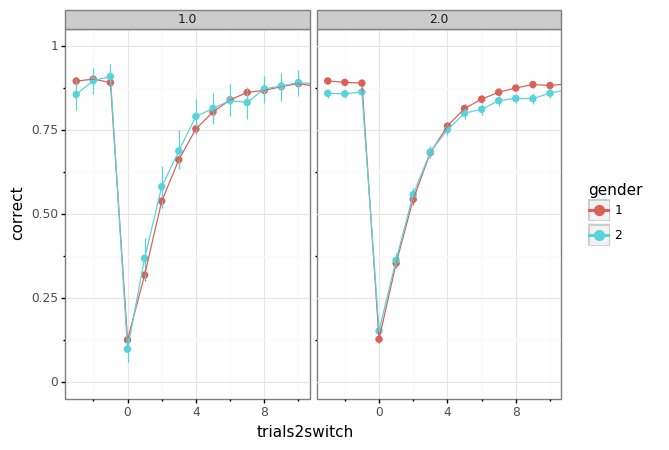

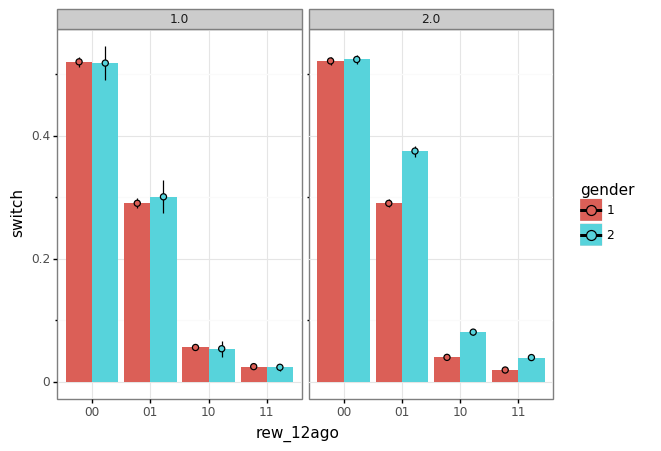

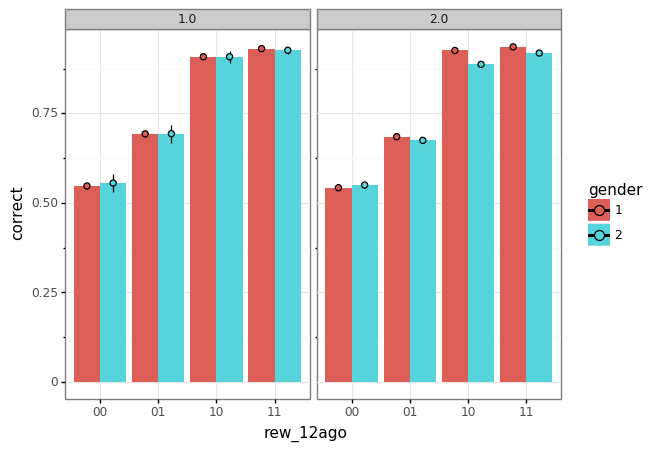

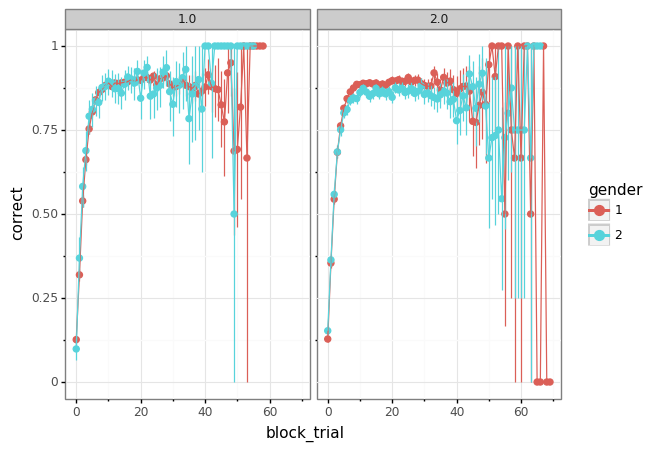

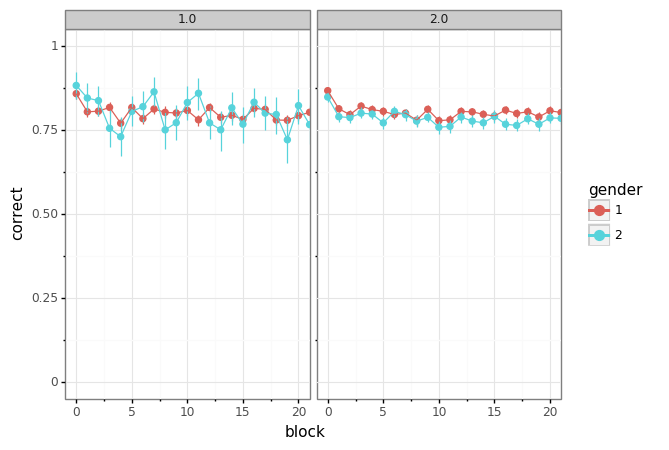

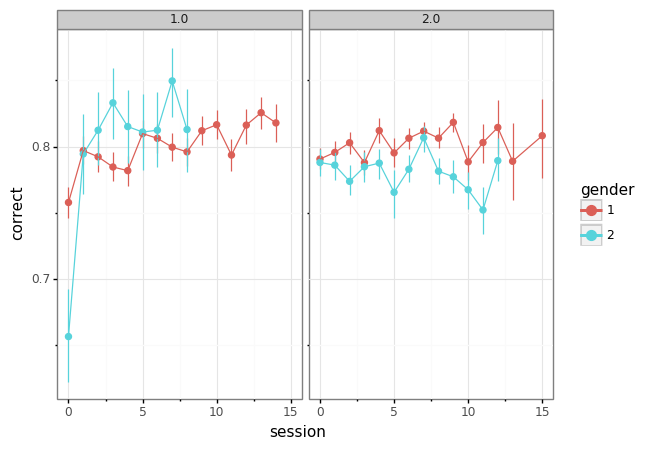

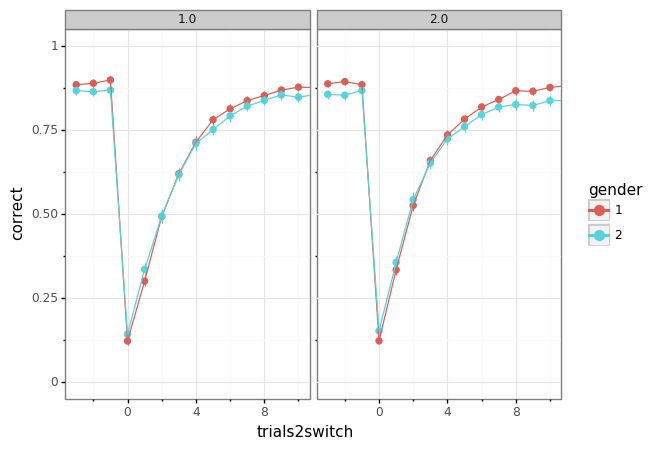

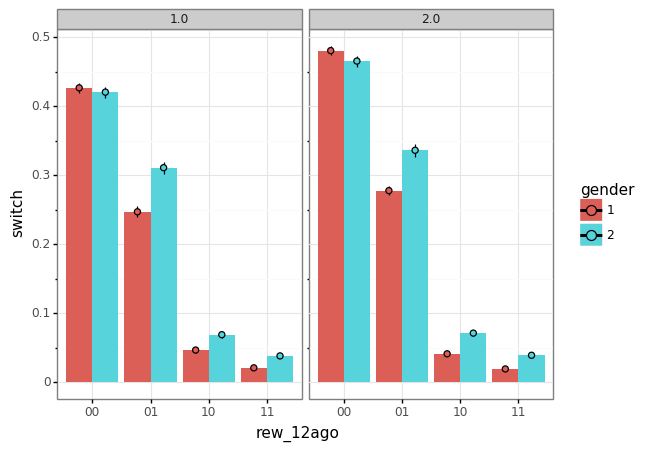

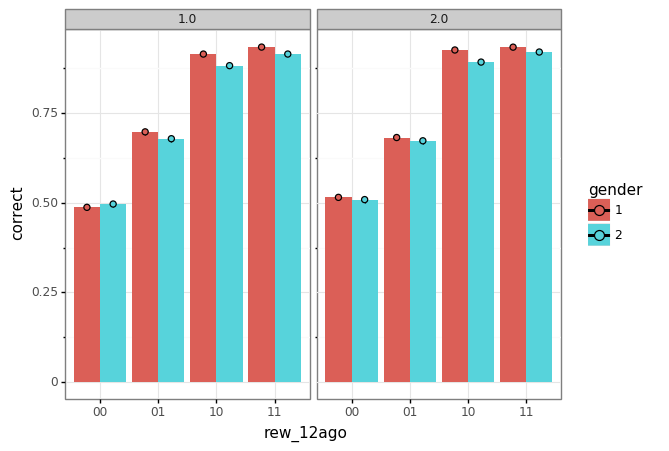

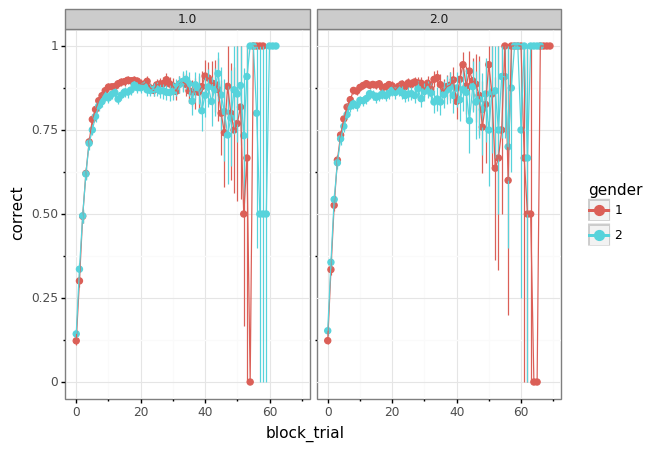

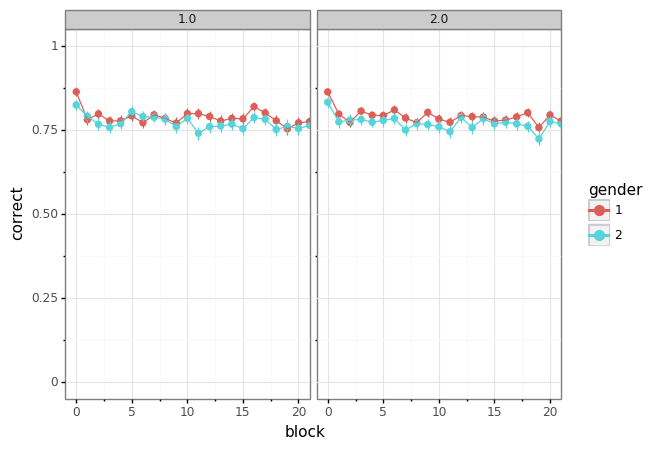

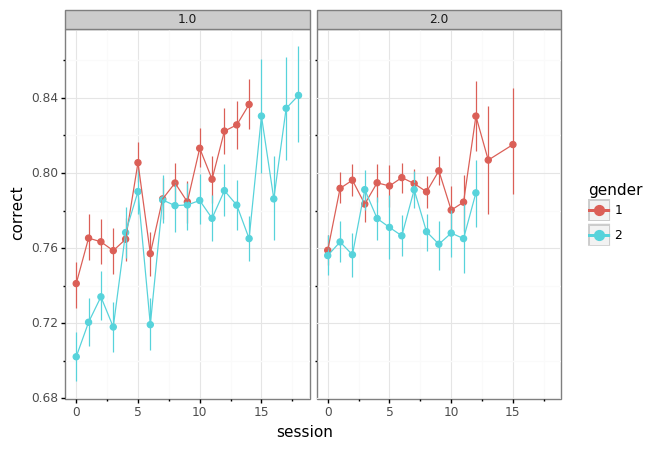

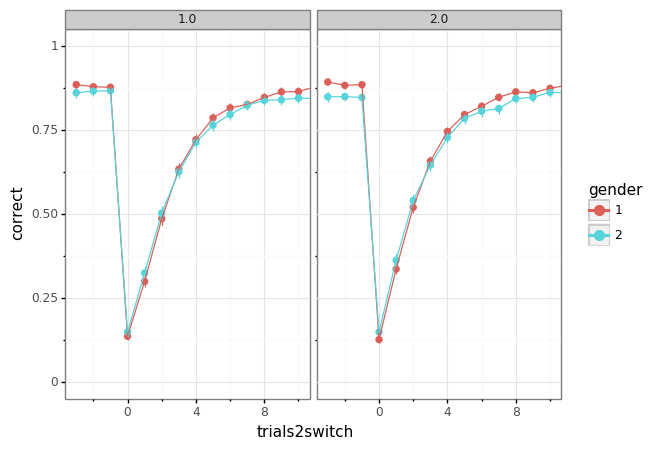

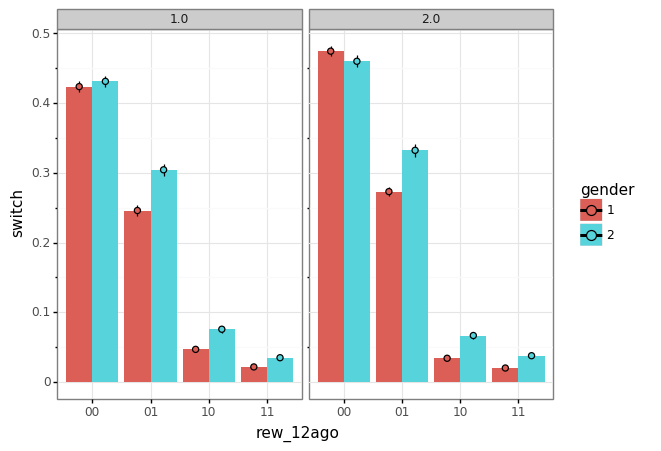

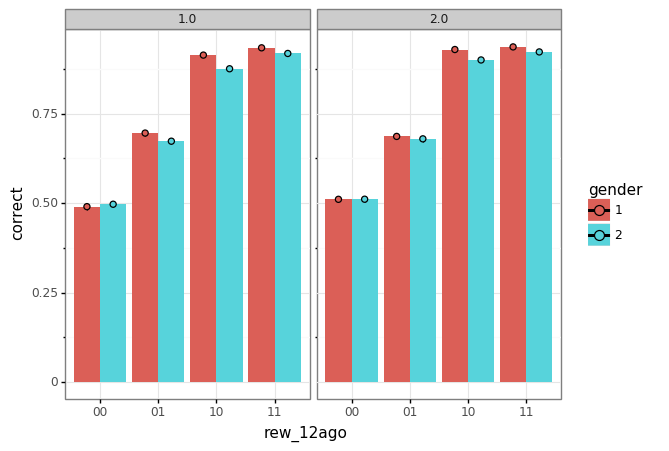

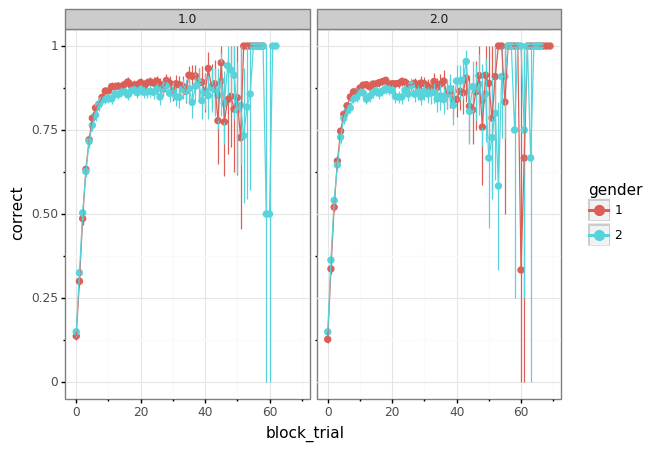

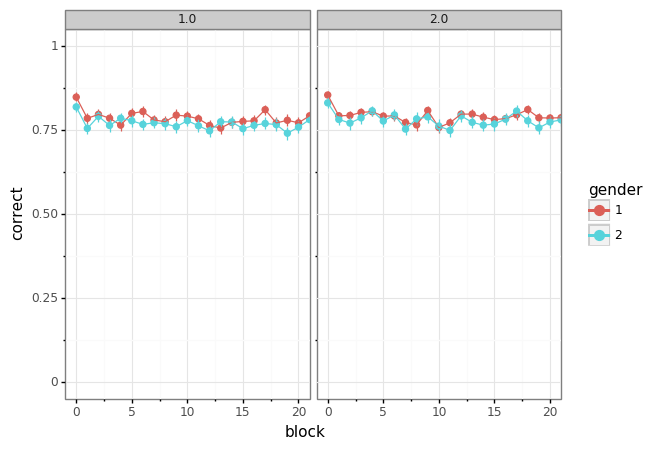

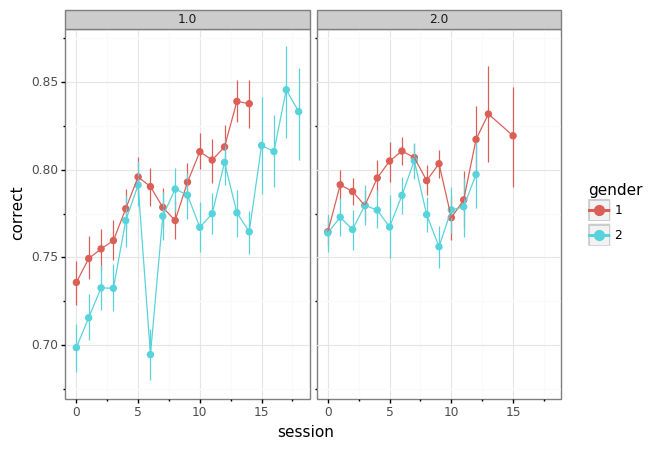

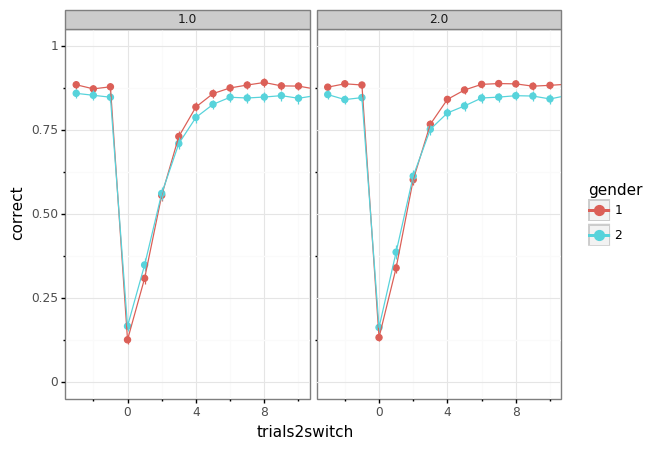

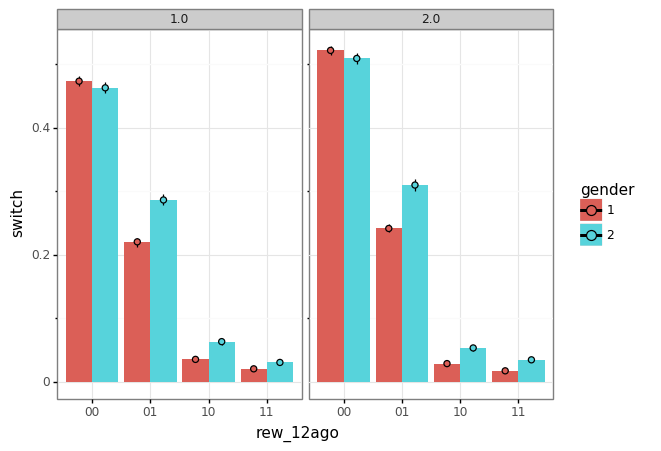

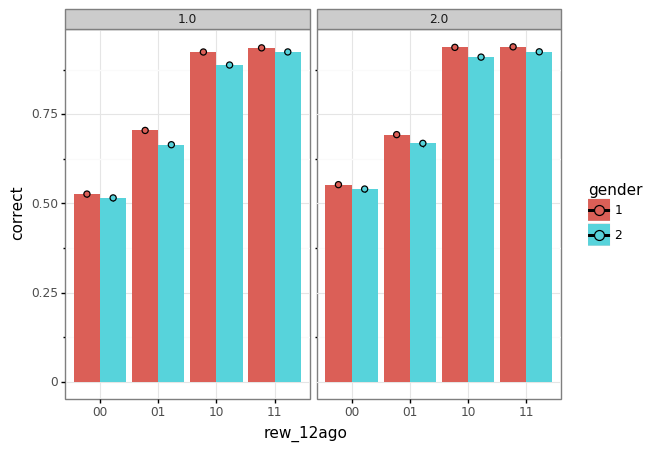

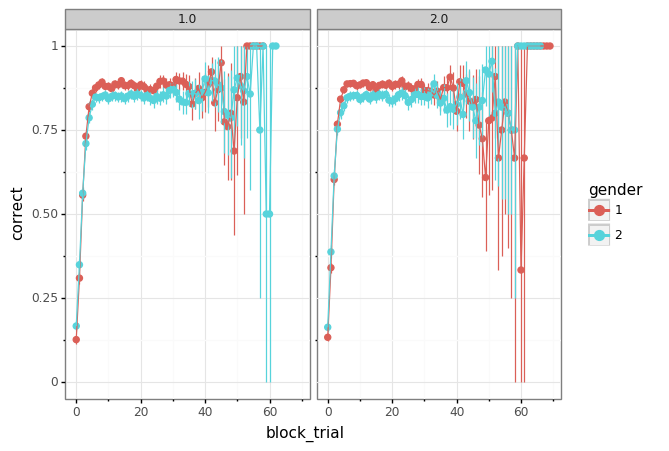

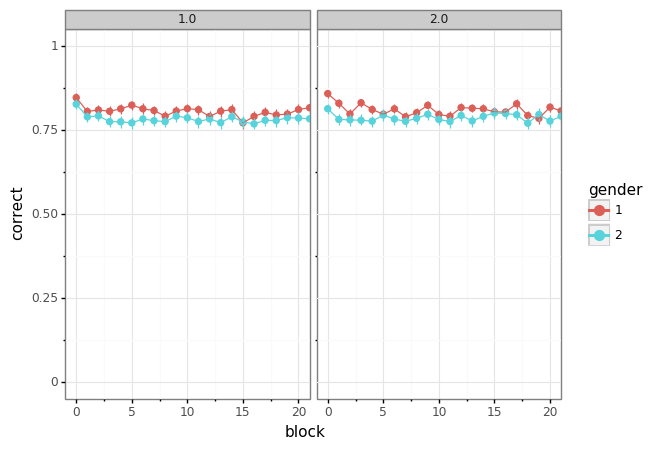

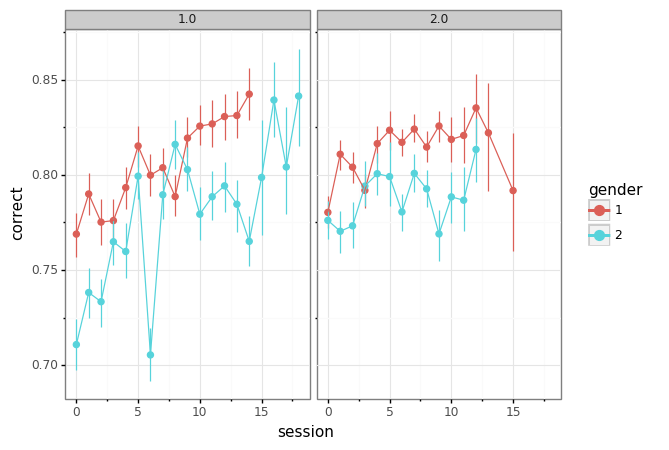

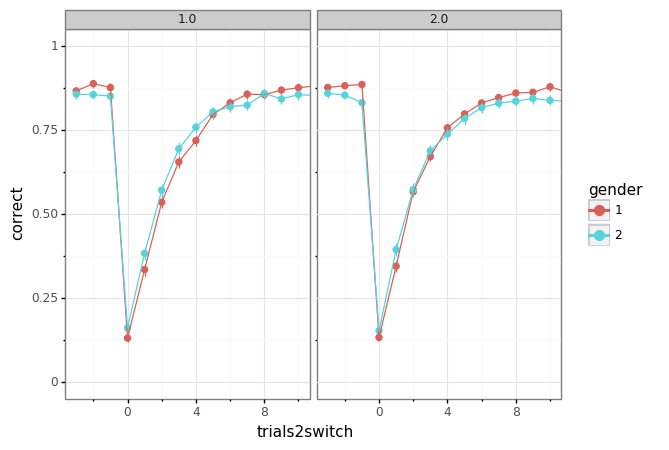

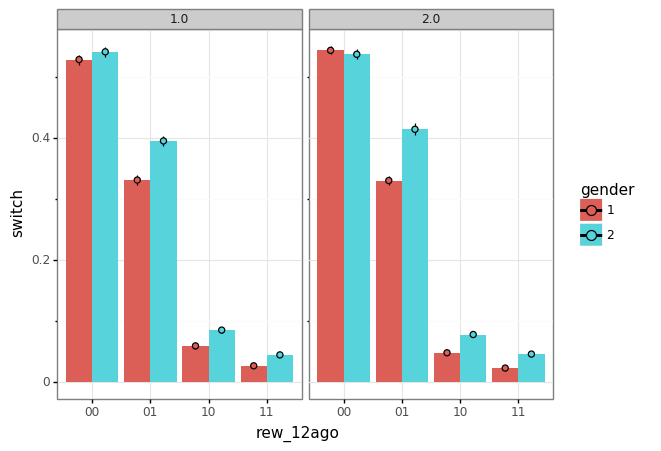

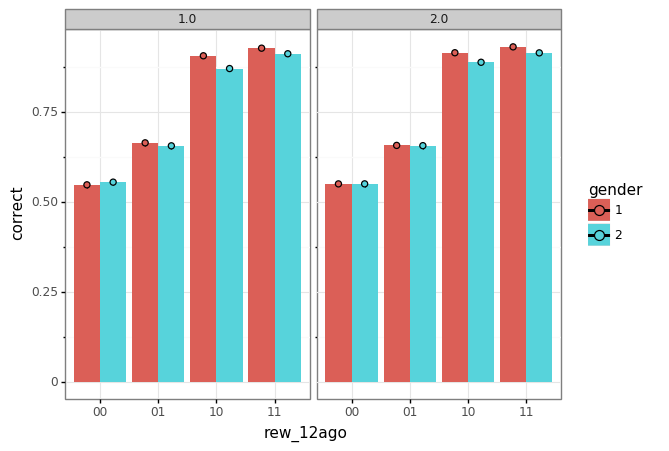

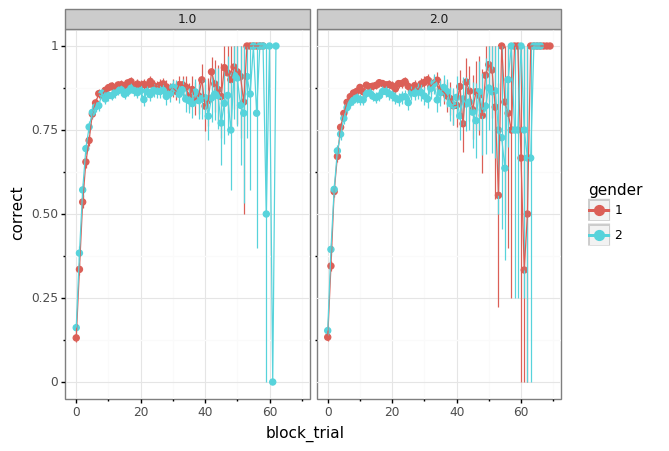

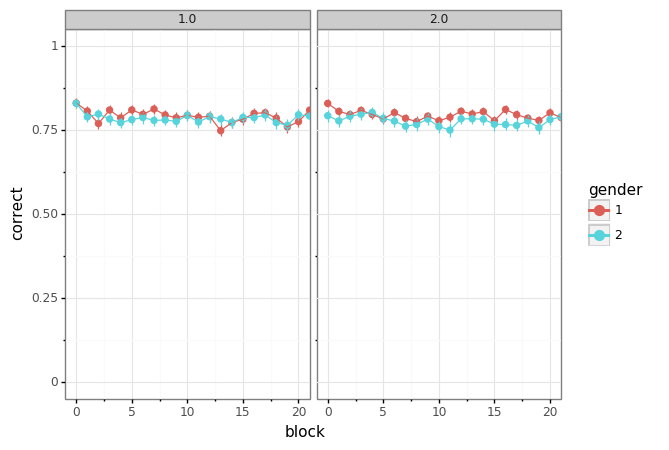

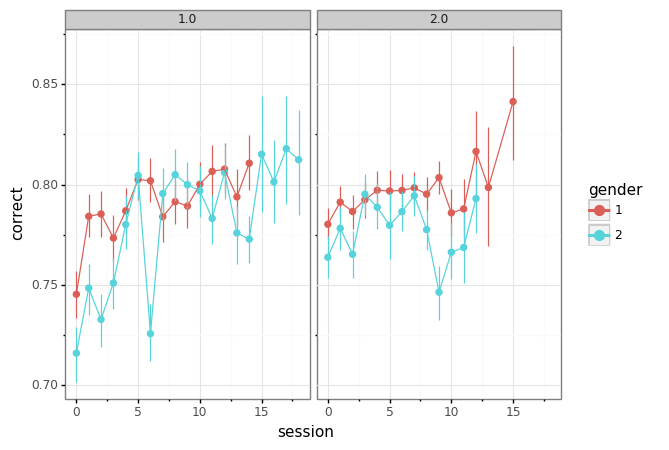

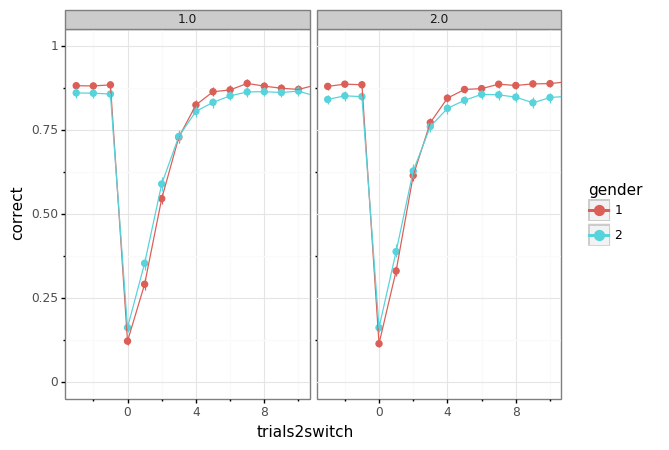

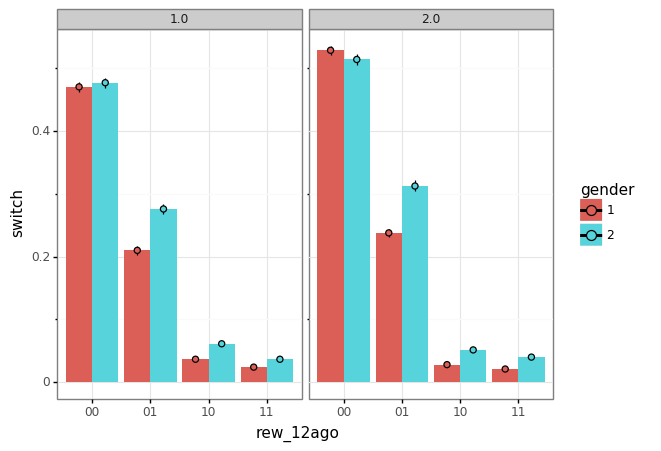

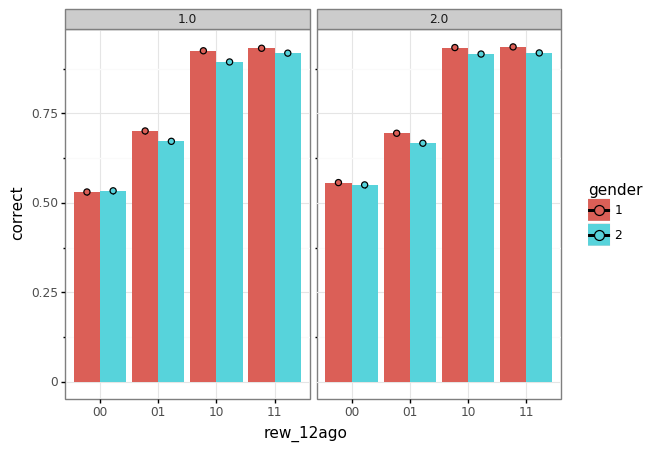

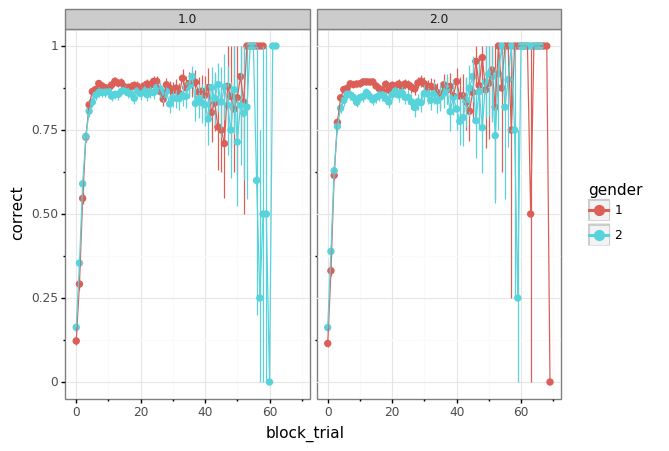

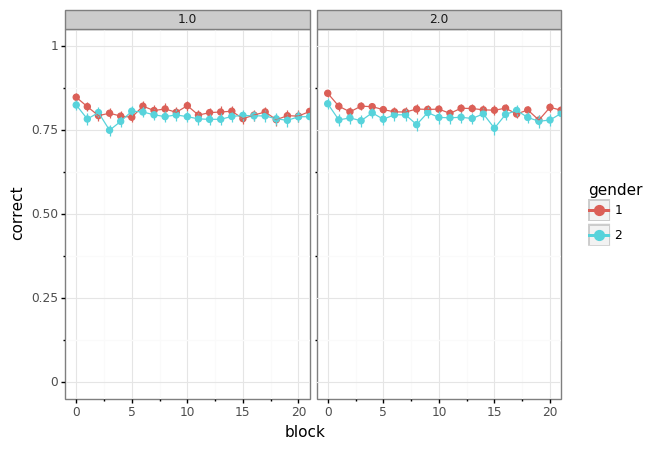

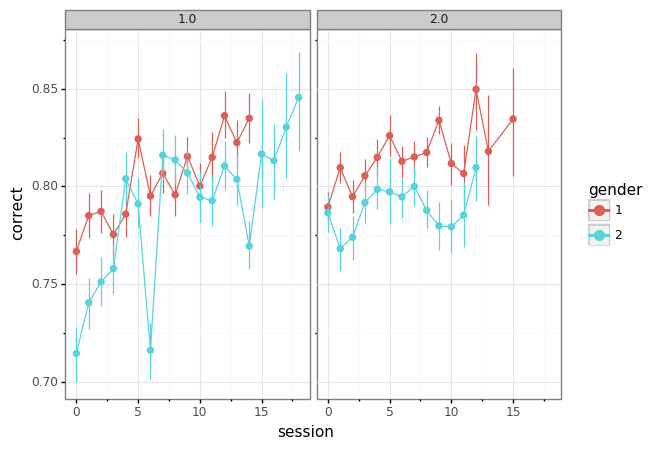

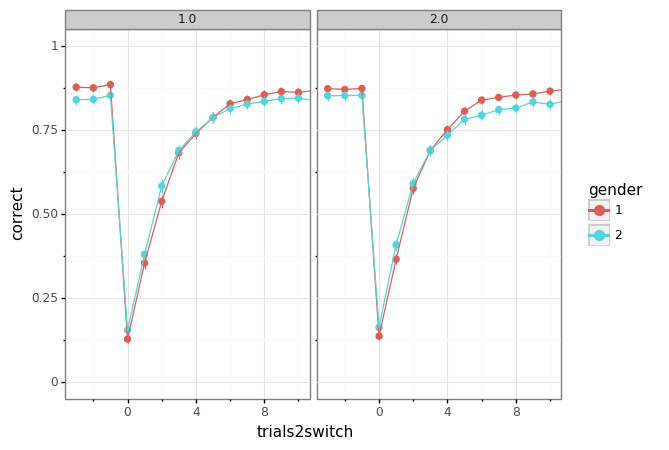

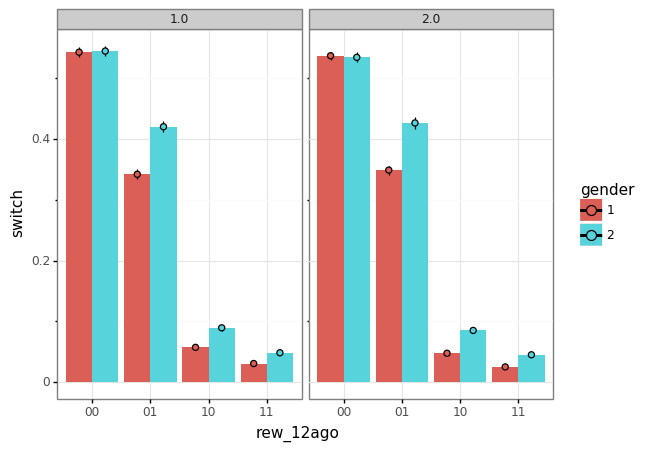

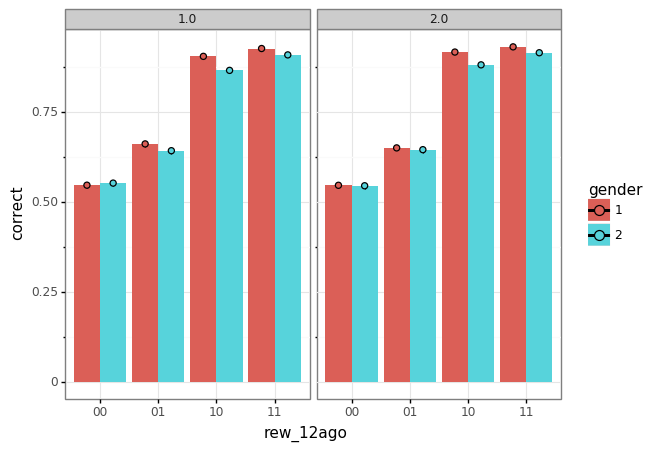

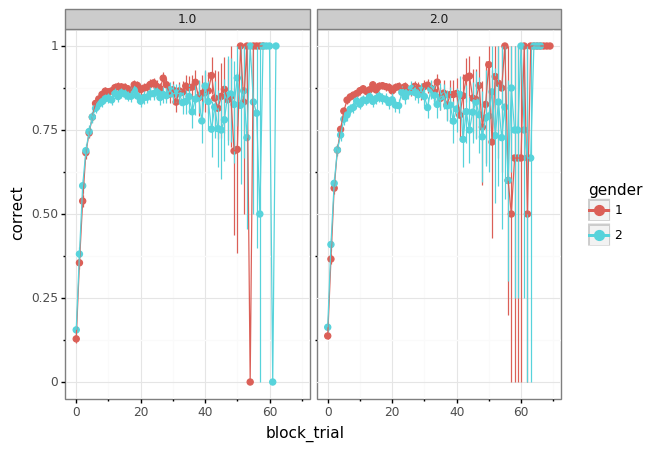

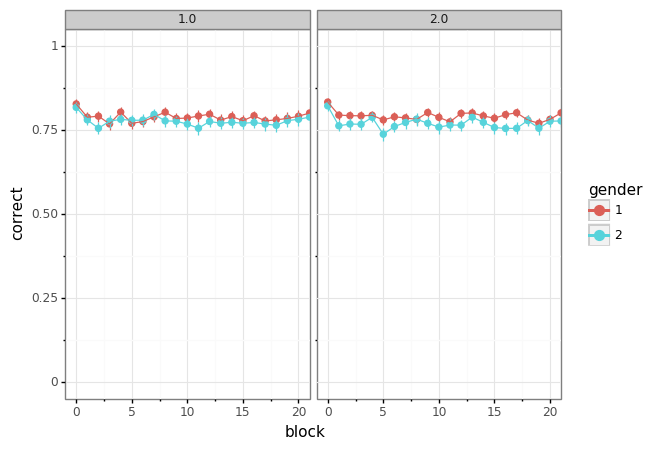

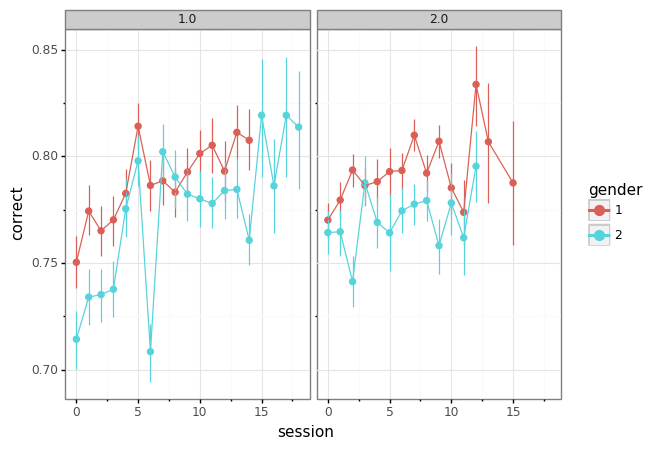

In [13]:
# Define simulations to be analzed
n_agents = 10
modelnames = [f for f in os.listdir(fitted_param_dir) if ('.csv' in f) and ('params' in f) and ('B' not in f)]
model_names = [modelname.split('_')[1] for modelname in modelnames]

# Read in and format simulated data
for model_name in model_names:
    print("Model {}".format(model_name))
    simulation_dir = os.path.join(fitted_param_dir, 'simulations/simulated_mice_{}_nagents{}.csv'.format(model_name, n_agents))
    if save_or_load_sim_mouse_dat == 'save':
        sim_dat = pd.read_csv(simulation_dir)
        sim_dat = format_sim_data(sim_dat, model_name, selected_mouse=0, save_as_csv=True)
    else:
        sim_dat = pd.read_csv(os.path.join(mouse_data_dir, 'formatted_sim_mouse_data_{}.csv'.format(model_name)))        
    
    # Plot simulated data
    print("Plotting...")
    make_trials2switch_plot(sim_dat, suf='sim' + model_name)
    make_12ago_plot(sim_dat, 'sim' + model_name)
    make_blocktrial_correct_plot(sim_dat, 'sim' + model_name)
    make_block_correct_plot(sim_dat, 'sim' + model_name)
    make_session_correct_plot(sim_dat, 'sim' + model_name)